In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib.style as style, matplotlib.colors as colors
import random
from scipy.stats import norm
%matplotlib inline
style.use("seaborn")
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.dpi"] = 93
plt.rcParams["figure.figsize"] = (5.2,5.2)

In [2]:
class POI(object):
    n_pois = 0
    
    def __init__(self, uid):
        POI.n_pois += 1
        self.history = []
        self.poid = POI.n_pois
        self.mappers = set([uid])
        self.n_edits = 0
        self.n_tags = 0
        
    def n_mappers(self):
        return len(self.mappers)

    def describe(self):
        return self.__dict__



class Mapper(object):
    n_mappers = 0
    mapathon = None
    #window = 10
    
    
    def __init__(self, p, s, p_action, p_modify, state):
        self.p = p
        self.s = s
        self.p_action = p_action
        self.p_modify = p_modify
        self.history = []
        Mapper.n_mappers += 1
        self.uid = Mapper.n_mappers
        self.n = 0
        self.origin = state
        
    def describe(self):
        return self.__dict__
  
        
    def membership(self, show=True):
        if self.n < Mapper.window:
            raise ValueError("This mapper has not interacted enough yet. (n={})".format(Mapper.window))
        else:
            self.ac = pd.Series([edit["action"] for edit in self.history ]).value_counts().idxmax()
            self.mc = pd.Series([edit["mod_type"] for edit in self.history]).value_counts().idxmax()
            self.ec = "A" if self.n > 13 else "B"#toy function
            print(self.ac, self.mc, self.ec) if show else None
        
    def action(self, environment, state):
        visited = [_["poid"] for _ in self.history ]
        visited_coords = [_ for _ in environment if environment[_] != None and environment[_].poid in visited]
        states = [_["state"] for _ in self.history]
        s = 0 if len(visited_coords) ==0 else self.s
        occupied = [i for i in environment if environment[i] != None]
        not_occupied = [i for i in environment if environment[i] == None]
        if np.random.binomial(1, self.p) == 1:  
            self.n += 1
            #Assumptions about priors
            action_type = np.random.choice(a=["create","modify", "delete"], p=self.p_action) if len(occupied) > 1 else "create"
            mod_type = np.random.choice(a=["tag_ch", "tag_del", "tag_add", "pos_ch"], p=self.p_modify) if action_type == "modify" else None
            if np.random.binomial(1, s) != 1:
                if action_type != "create":
                    env_choice = random.choice(occupied)
                else:
                    if len(not_occupied) > 0:
                        env_choice = random.choice(not_occupied)
                    else:
                        action_type = random.choice(["modify","delete"])
                        env_choice = random.choice(occupied)
                        
                
                    env_choice = random.choice(not_occupied) if action_type== "create" else random.choice(occupied)
            else:
                
                random_visited = random.choice(visited_coords)
                coord = random_visited
                for c in [(random_visited[0]+1, random_visited[1]),
                                           (random_visited[0]-1, random_visited[1]),
                                           (random_visited[0], random_visited[1]-1),
                                           (random_visited[0], random_visited[1]+1)]:
                    if c in environment:
                        env_choice = c
                

            if action_type == "create":
                poi = POI(self.uid)
                environment[env_choice] = poi
            elif action_type =="delete":
                poi = environment[env_choice]
                if poi==None:
                    poi = environment[random.choice(visited_coords)]
                poi.mappers.add(self.uid)
                environment[env_choice] = None
            elif action_type == "modify":
                poi = environment[env_choice]
                if poi==None:
                    poi = environment[random.choice(visited_coords)]
                poi.mappers.add(self.uid)
                poi.n_edits += 1
                if mod_type == "tag_add":
                    poi.n_tags += 1
                elif mod_type == "tag_del":
                    poi.n_tags -= 1      

            self.history.append({ "action" : action_type, "mod_type" : mod_type, "poid" : poi.poid, "state" : state })
            poi.history.append({ "action" : action_type, "mod_type" : mod_type, "uid" : self.uid, "state" : state  })

        else:
            return

    @classmethod 
    def simulate_mapathon(cls, kind):
        cls.mapathon = kind
        pass
        
        
def map_state(environment):
    x = [i[0] for i in environment.keys()]
    y = [i[1] for i in environment.keys()]
    occupied_x = [i[0] for i in environment if environment[i] != None]
    occupied_y = [i[1] for i in environment if environment[i] != None]
    ax = plt.scatter(x,y,s=8.9)
    plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.yticks(np.arange(min(y), max(y)+1, 1.0))
    plt.scatter(occupied_x, occupied_y, color="red")
    plt.axis("off")

In [54]:
def random_priors(n):
    ints=np.random.randint(2,1000, size=n)
    return list(ints/ints.sum())

def run_sim(n_mappers, T, new_mapper_prob, p,
            p_action, p_modify,
            grid_dim=50, s=0.2, stationary=[True,True] ):
    # Simulate
    state=0
    Mapper.n_mappers = 0
    POI.n_pois = 0
    #Instantiate Environment and mappers
    environment = {(i, j) : None for i in range(1, grid_dim+1) for j in range(1, grid_dim+1)}
    mappers = [Mapper(p,s,p_action,p_modify,state) for i in range(n_mappers)]
    #Run
    for i in range(T):
        state += 1
        # new mappers can potentially join 
        if np.random.binomial(1, new_mapper_prob) == 1:
            mappers.append(Mapper(p,s,p_action,p_modify,state))
        for mapper in mappers:
            if state >= T/2:
                if not stationary[0]:
                    mapper.p_action = random_priors(3)

                if not stationary[1]:
                    mapper.p_modify = random_priors(4)
                
            mapper.action(environment, state)
                
    data = []
    for slot in environment:
        if environment[slot]!=None:
            data += environment[slot].history


    df = pd.DataFrame(data).sort_values(by="state")

    df["create"] = df.action.apply(lambda x : 1 if x== "create" else 0)
    df["modify"] = df.action.apply(lambda x : 1 if x== "modify" else 0)
    df["delete"] = df.action.apply(lambda x : 1 if x== "delete" else 0)
    del df["action"]

    df["pos_ch"] = df.mod_type.apply(lambda x : 1 if x== "pos_ch" else 0)
    df["tag_add"] = df.mod_type.apply(lambda x : 1 if x== "tag_add" else 0)
    df["tag_del"] = df.mod_type.apply(lambda x : 1 if x== "tag_del" else 0)
    df["tag_ch"] = df.mod_type.apply(lambda x : 1 if x== "tag_ch" else 0)
    del df["mod_type"]
    del df["uid"]
    #map_state(environment)
    df = df.groupby("state").sum()
    df = df.reindex(list(range(1, T+1))).replace(np.nan, 0)
    return df, environment

### Simulation Parameters

- p := Prob. of taking an action at every tick
- s := Spatial Preference Factor (Prob. of taking action in a spatially known area)
- T := Total ticks
- new_mapper_prob := Prob. of New mapper spawning at a tick
- p_action := Probability-prior vector for action types
- p_modify := Probability-prior vector for modification types
- grid_dim := environment size
- stationarity := stationarity of both priors

## Sim 1 - Single Mapper Simulation 

In [49]:
n_mappers = 1
T = 500
new_mapper_prob = 0
p = 0.25
s = 0
p_action = [0.3, 0.6, 0.1]
p_modify = [0.25,0.25,0.25,0.25]
df, env = run_sim(
    n_mappers,
    T,
    new_mapper_prob,
    p,
    p_action,
    p_modify,
    s=s,
    grid_dim=20)

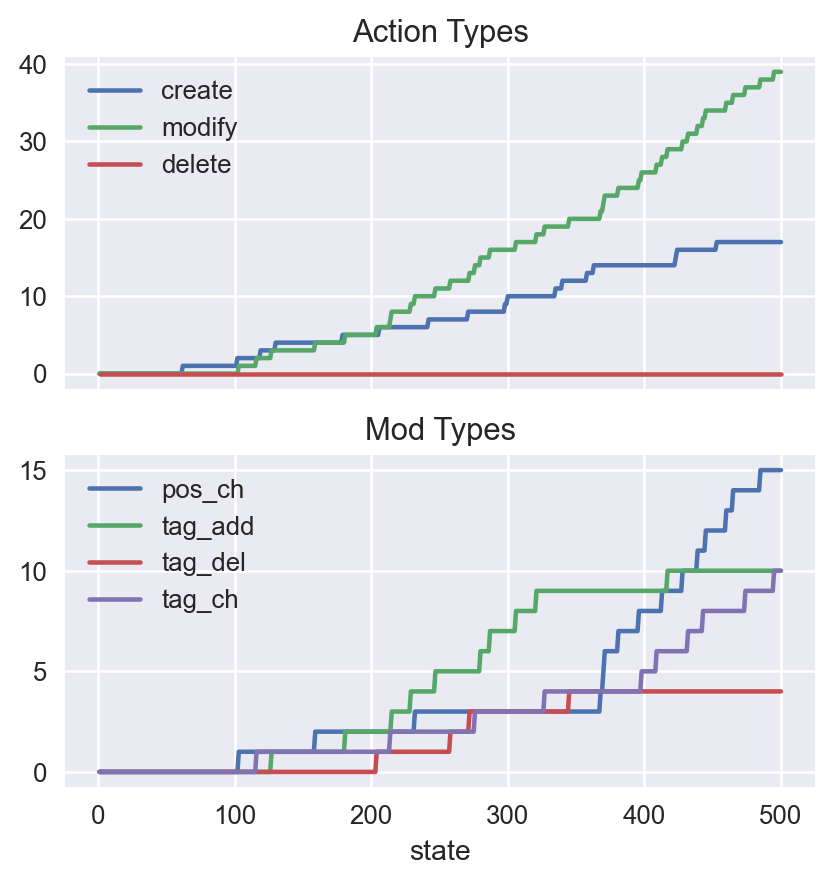

In [10]:
fig, axes = plt.subplots(ncols=1,nrows=2,sharex=True)
df[['create', 'modify', 'delete']].cumsum().plot(ax=axes[0], title="Action Types")
df[['pos_ch', 'tag_add', 'tag_del', 'tag_ch']].cumsum().plot(ax=axes[1], title="Mod Types");

## Sim 2 - Single Mapper with new spawning mappers

In [11]:
n_mappers = 1
T = 500
new_mapper_prob = 0.05
p = 0.25
s = 0
p_action = [0.3, 0.6, 0.1]
p_modify = [0.25,0.25,0.25,0.25]
df, env = run_sim(
    n_mappers,
    T,
    new_mapper_prob,
    p,
    p_action,
    p_modify,
    s=s,
    grid_dim=20)

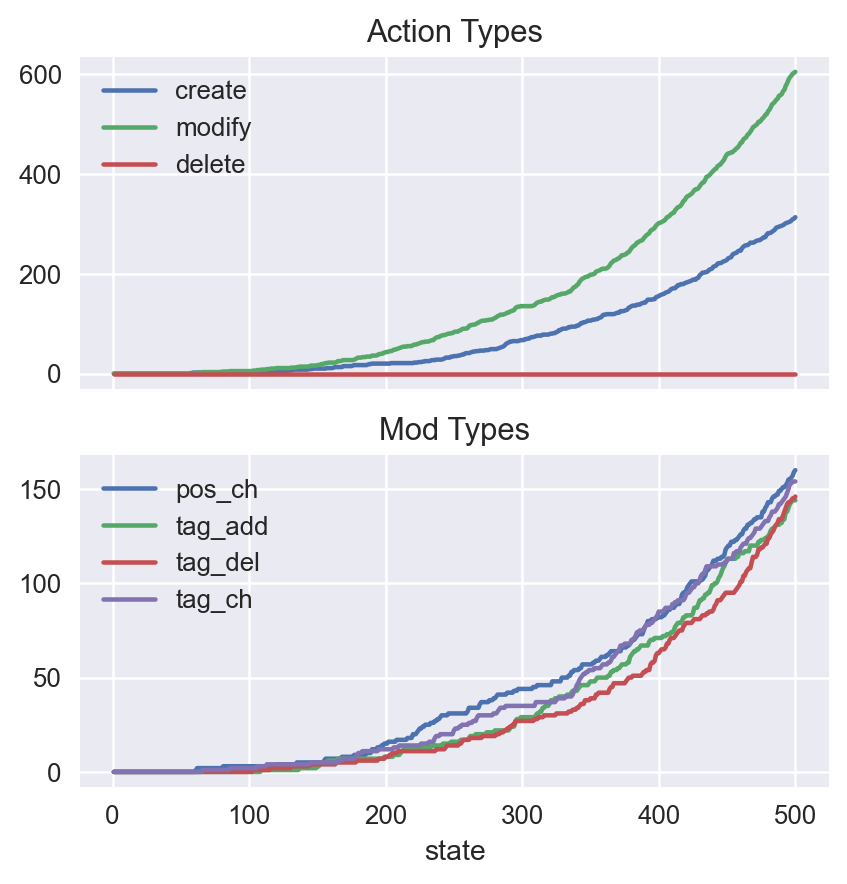

In [12]:
fig, axes = plt.subplots(ncols=1,nrows=2,sharex=True)
df[['create', 'modify', 'delete']].cumsum().plot(ax=axes[0], title="Action Types")
df[['pos_ch', 'tag_add', 'tag_del', 'tag_ch']].cumsum().plot(ax=axes[1], title="Mod Types");

## Sim 3 - Single Mapper high spatial preference

In [13]:
n_mappers = 1
T = 500
new_mapper_prob = 0
p = 0.25
s = 0.75
p_action = [0.3, 0.6, 0.1]
p_modify = [0.25,0.25,0.25,0.25]
df, env = run_sim(
    n_mappers,
    T,
    new_mapper_prob,
    p,
    p_action,
    p_modify,
    s=s,
    grid_dim=20)

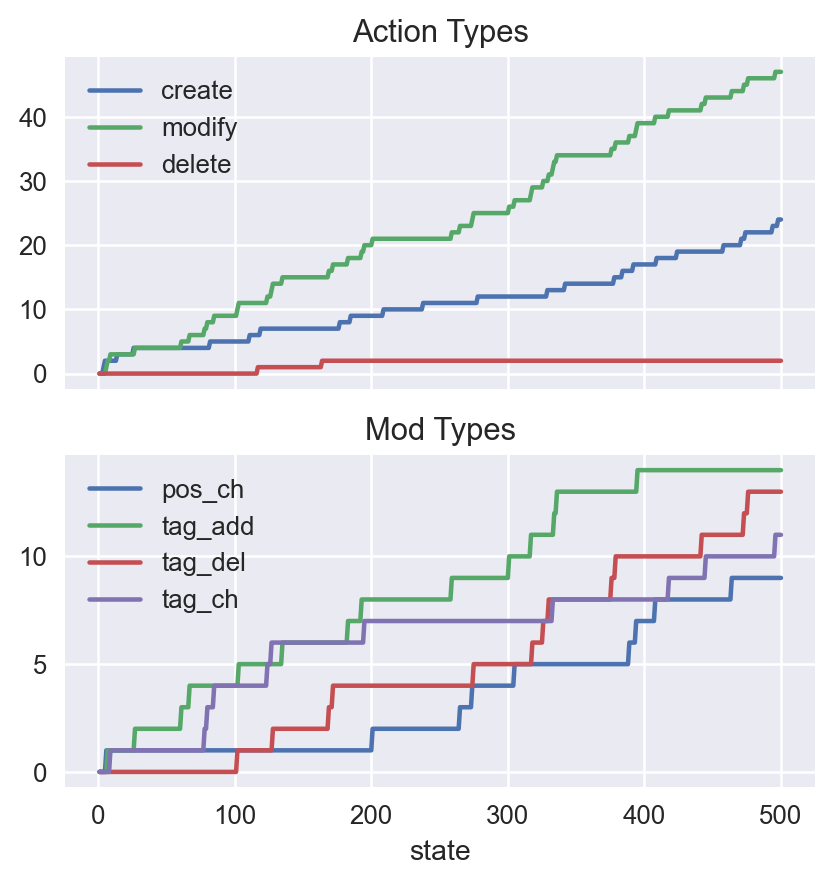

In [14]:
fig, axes = plt.subplots(ncols=1,nrows=2,sharex=True)
df[['create', 'modify', 'delete']].cumsum().plot(ax=axes[0], title="Action Types")
df[['pos_ch', 'tag_add', 'tag_del', 'tag_ch']].cumsum().plot(ax=axes[1], title="Mod Types");

## Sim 3 - Multi Mapper Simulation with stationary action and modify priors

In [15]:
n_mappers = 10
T = 500
new_mapper_prob = 0
p = 0.25
s = 0
p_action = [0.3, 0.6, 0.1]
p_modify = [0.25,0.25,0.25,0.25]
df, env = run_sim(
    n_mappers,
    T,
    new_mapper_prob,
    p,
    p_action,
    p_modify,
    s=s,
    grid_dim=20)

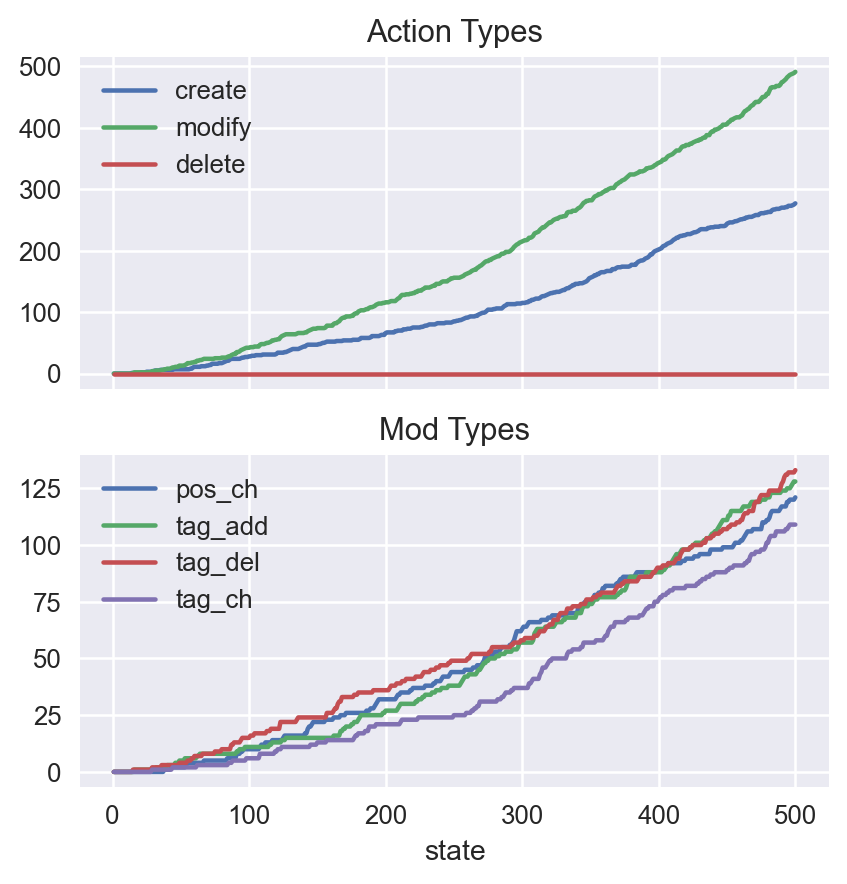

In [16]:
fig, axes = plt.subplots(ncols=1,nrows=2,sharex=True)
df[['create', 'modify', 'delete']].cumsum().plot(ax=axes[0], title="Action Types")
df[['pos_ch', 'tag_add', 'tag_del', 'tag_ch']].cumsum().plot(ax=axes[1], title="Mod Types");

## Sim 3 - Single Mapper non-stationary action and modify priors

In [64]:
n_mappers = 1
T = 2000
new_mapper_prob = 0.0
p = 0.5
s = 0
p_action = [0.3, 0.6, 0.1]
p_modify = [0.25,0.25,0.25,0.25]
df, env = run_sim(
    n_mappers,
    T,
    new_mapper_prob,
    p,
    p_action,
    p_modify,
    s=s,
    grid_dim=20,
    stationary=[False, False])

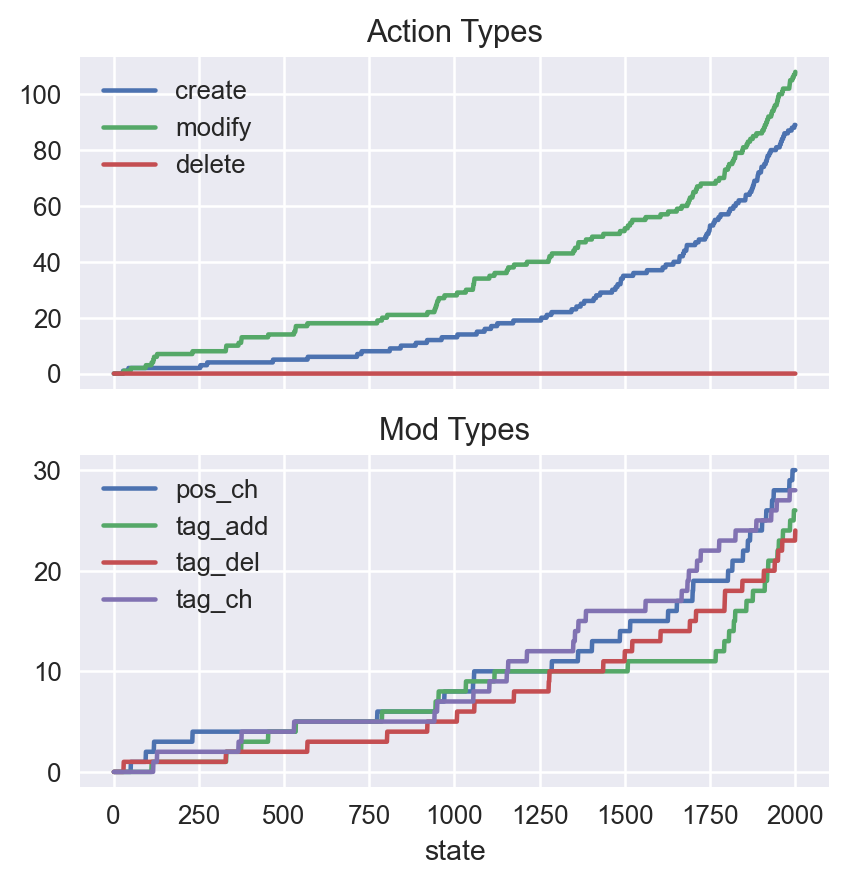

In [65]:
fig, axes = plt.subplots(ncols=1,nrows=2,sharex=True)
df[['create', 'modify', 'delete']].cumsum().plot(ax=axes[0], title="Action Types")
df[['pos_ch', 'tag_add', 'tag_del', 'tag_ch']].cumsum().plot(ax=axes[1], title="Mod Types");

## Sim 4 - Multi Mapper non-stationary action and modify priors

In [62]:
n_mappers = 1
T = 2000
new_mapper_prob = 0.0
p = 0.5
s = 0
p_action = [0.3, 0.6, 0.1]
p_modify = [0.25,0.25,0.25,0.25]
df, env = run_sim(
    n_mappers,
    T,
    new_mapper_prob,
    p,
    p_action,
    p_modify,
    s=s,
    grid_dim=20,
    stationary=[False, False])

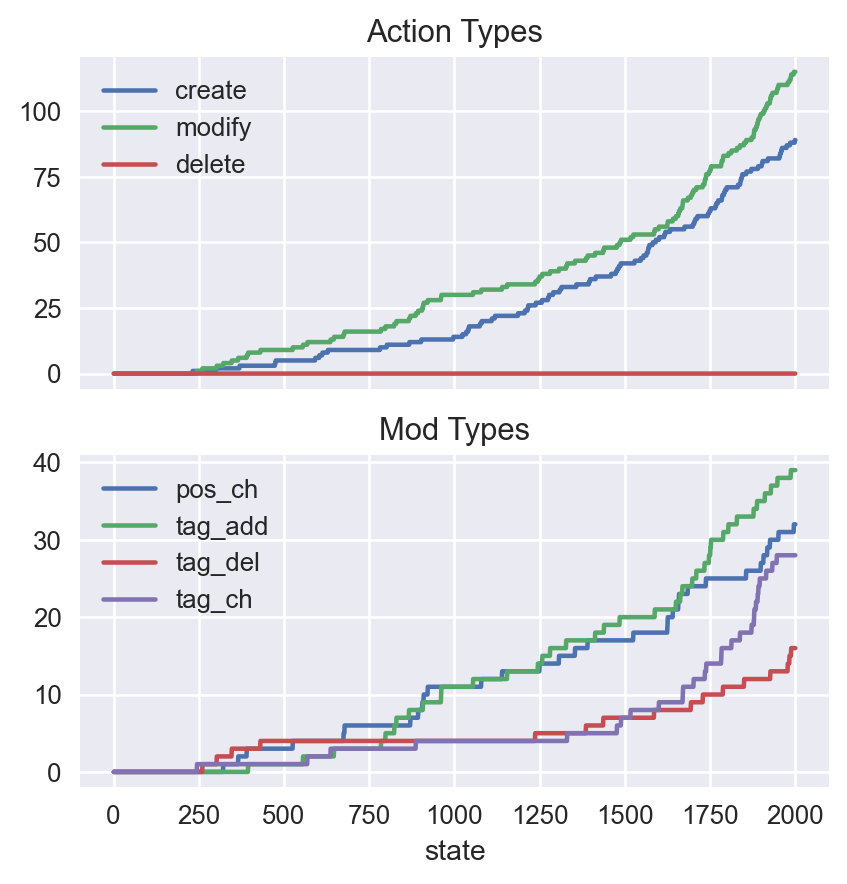

In [63]:
fig, axes = plt.subplots(ncols=1,nrows=2,sharex=True)
df[['create', 'modify', 'delete']].cumsum().plot(ax=axes[0], title="Action Types")
df[['pos_ch', 'tag_add', 'tag_del', 'tag_ch']].cumsum().plot(ax=axes[1], title="Mod Types");